# Test a meta-reinforcement learning model (A2C) on the two-step task

## What is meta-reinforcement learning?

TODO: explain meta-reinforcement learning

### Let's setup the environment

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## What is the two step task, and why should I care?

P1: explain model-free and model-based behavior in cognitive science

P2: two-step task is an iconic experiment demonstrating that humans have the ability to learn in a model-based manner.

P3: add maybe a figure to explain how the two-step task should work.

## Finally, let's train the model

In [2]:
from envs.Collins2018 import Collins2018Task
from stable_baselines.common.env_checker import check_env
from numpy.random import randint

env = Collins2018Task(num_objects=(6, 8))
check_env(env)
env.reset()
for i in range(10):
    env.step(randint(3))
    env.render()

t =  1
action is  1
observation is  2
reward is  0
next state is  [1 1 0]
target in this episode is  [0 2 0 2 2 1]


t =  2
action is  0
observation is  1
reward is  0
next state is  [0 0 0]
target in this episode is  [0 2 0 2 2 1]


t =  3
action is  1
observation is  0
reward is  0
next state is  [0 1 0]
target in this episode is  [0 2 0 2 2 1]


t =  4
action is  2
observation is  0
reward is  0
next state is  [2 2 0]
target in this episode is  [0 2 0 2 2 1]


t =  5
action is  1
observation is  2
reward is  0
next state is  [5 1 0]
target in this episode is  [0 2 0 2 2 1]


t =  6
action is  2
observation is  5
reward is  0
next state is  [5 2 0]
target in this episode is  [0 2 0 2 2 1]


t =  7
action is  1
observation is  5
reward is  1
next state is  [3 1 1]
target in this episode is  [0 2 0 2 2 1]


t =  8
action is  0
observation is  3
reward is  0
next state is  [1 0 0]
target in this episode is  [0 2 0 2 2 1]


t =  9
action is  0
observation is  1
reward is  0
next state is

In [3]:
from envs.GuessBoundary import GuessBoundaryTask
from utils.utils import do_experiment

# specify the agent and the environment
num_lstm_units = 30
num_train_steps = 20_000_000
policy_kwargs = {'n_lstm': num_lstm_units, 'action_noise': 0}
env = GuessBoundaryTask(obs_mode='all_history')

do_experiment(env, num_train_steps, policy_kwargs)

---------------------------------
| explained_variance | -5.46    |
| fps                | 6        |
| nupdates           | 1        |
| policy_entropy     | 3.88     |
| total_timesteps    | 20       |
| value_loss         | 0.159    |
---------------------------------
---------------------------------
| ep_len_mean        | 54.8     |
| ep_reward_mean     | 1        |
| explained_variance | -7.81    |
| fps                | 540      |
| nupdates           | 1000     |
| policy_entropy     | 3.9      |
| total_timesteps    | 20000    |
| value_loss         | 0.00687  |
---------------------------------
---------------------------------
| ep_len_mean        | 46.6     |
| ep_reward_mean     | 1        |
| explained_variance | 0.673    |
| fps                | 787      |
| nupdates           | 1        |
| policy_entropy     | 3.89     |
| total_timesteps    | 25020    |
| value_loss         | 0.0332   |
---------------------------------
---------------------------------
| ep_len_mean 

---------------------------------
| ep_len_mean        | 43.8     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0755   |
| fps                | 986      |
| nupdates           | 1        |
| policy_entropy     | 3.89     |
| total_timesteps    | 275020   |
| value_loss         | 0.243    |
---------------------------------
---------------------------------
| ep_len_mean        | 35.9     |
| ep_reward_mean     | 1        |
| explained_variance | -0.187   |
| fps                | 1013     |
| nupdates           | 1000     |
| policy_entropy     | 3.88     |
| total_timesteps    | 295000   |
| value_loss         | 0.0271   |
---------------------------------
---------------------------------
| ep_len_mean        | 35.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.508    |
| fps                | 986      |
| nupdates           | 1        |
| policy_entropy     | 3.84     |
| total_timesteps    | 300020   |
| value_loss         | 0.0305   |
--------------

---------------------------------
| ep_len_mean        | 24.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.375    |
| fps                | 1011     |
| nupdates           | 1000     |
| policy_entropy     | 3.79     |
| total_timesteps    | 595000   |
| value_loss         | 0.0588   |
---------------------------------
---------------------------------
| ep_len_mean        | 24.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0666   |
| fps                | 906      |
| nupdates           | 1        |
| policy_entropy     | 3.83     |
| total_timesteps    | 600020   |
| value_loss         | 0.112    |
---------------------------------
---------------------------------
| ep_len_mean        | 24       |
| ep_reward_mean     | 1        |
| explained_variance | 0.178    |
| fps                | 995      |
| nupdates           | 1000     |
| policy_entropy     | 3.76     |
| total_timesteps    | 620000   |
| value_loss         | 0.0851   |
--------------

---------------------------------
| ep_len_mean        | 19.6     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0991   |
| fps                | 950      |
| nupdates           | 1        |
| policy_entropy     | 3.75     |
| total_timesteps    | 900020   |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| ep_len_mean        | 17.7     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0946   |
| fps                | 897      |
| nupdates           | 1000     |
| policy_entropy     | 3.79     |
| total_timesteps    | 920000   |
| value_loss         | 0.0598   |
---------------------------------
---------------------------------
| ep_len_mean        | 18.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.00894  |
| fps                | 1002     |
| nupdates           | 1        |
| policy_entropy     | 3.83     |
| total_timesteps    | 925020   |
| value_loss         | 0.0949   |
--------------

---------------------------------
| ep_len_mean        | 14.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.445    |
| fps                | 1002     |
| nupdates           | 1000     |
| policy_entropy     | 3.65     |
| total_timesteps    | 1220000  |
| value_loss         | 0.0577   |
---------------------------------
---------------------------------
| ep_len_mean        | 17.5     |
| ep_reward_mean     | 1        |
| explained_variance | 0.402    |
| fps                | 984      |
| nupdates           | 1        |
| policy_entropy     | 3.35     |
| total_timesteps    | 1225020  |
| value_loss         | 0.104    |
---------------------------------
---------------------------------
| ep_len_mean        | 16.4     |
| ep_reward_mean     | 1        |
| explained_variance | 0.293    |
| fps                | 1001     |
| nupdates           | 1000     |
| policy_entropy     | 3.42     |
| total_timesteps    | 1245000  |
| value_loss         | 0.0941   |
--------------

---------------------------------
| ep_len_mean        | 13.7     |
| ep_reward_mean     | 1        |
| explained_variance | 0.262    |
| fps                | 861      |
| nupdates           | 1        |
| policy_entropy     | 3.49     |
| total_timesteps    | 1525020  |
| value_loss         | 0.0528   |
---------------------------------
---------------------------------
| ep_len_mean        | 12.8     |
| ep_reward_mean     | 1        |
| explained_variance | 0.579    |
| fps                | 997      |
| nupdates           | 1000     |
| policy_entropy     | 3.57     |
| total_timesteps    | 1545000  |
| value_loss         | 0.0737   |
---------------------------------
---------------------------------
| ep_len_mean        | 13.5     |
| ep_reward_mean     | 1        |
| explained_variance | 0.197    |
| fps                | 976      |
| nupdates           | 1        |
| policy_entropy     | 3.65     |
| total_timesteps    | 1550020  |
| value_loss         | 0.0638   |
--------------

---------------------------------
| ep_len_mean        | 13.6     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0521   |
| fps                | 953      |
| nupdates           | 1000     |
| policy_entropy     | 3.56     |
| total_timesteps    | 1845000  |
| value_loss         | 0.0811   |
---------------------------------
---------------------------------
| ep_len_mean        | 12.6     |
| ep_reward_mean     | 1        |
| explained_variance | 0.44     |
| fps                | 990      |
| nupdates           | 1        |
| policy_entropy     | 3.57     |
| total_timesteps    | 1850020  |
| value_loss         | 0.0808   |
---------------------------------
---------------------------------
| ep_len_mean        | 11.7     |
| ep_reward_mean     | 1        |
| explained_variance | 0.435    |
| fps                | 928      |
| nupdates           | 1000     |
| policy_entropy     | 3.72     |
| total_timesteps    | 1870000  |
| value_loss         | 0.0447   |
--------------

---------------------------------
| ep_len_mean        | 11.4     |
| ep_reward_mean     | 1        |
| explained_variance | 0.323    |
| fps                | 871      |
| nupdates           | 1        |
| policy_entropy     | 3.6      |
| total_timesteps    | 2150020  |
| value_loss         | 0.041    |
---------------------------------
---------------------------------
| ep_len_mean        | 13.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.777    |
| fps                | 909      |
| nupdates           | 1000     |
| policy_entropy     | 3.5      |
| total_timesteps    | 2170000  |
| value_loss         | 0.016    |
---------------------------------
---------------------------------
| ep_len_mean        | 12.6     |
| ep_reward_mean     | 1        |
| explained_variance | 0.34     |
| fps                | 1019     |
| nupdates           | 1        |
| policy_entropy     | 3.45     |
| total_timesteps    | 2175020  |
| value_loss         | 0.0406   |
--------------

---------------------------------
| ep_len_mean        | 11.9     |
| ep_reward_mean     | 1        |
| explained_variance | -0.0384  |
| fps                | 1011     |
| nupdates           | 1000     |
| policy_entropy     | 3.57     |
| total_timesteps    | 2470000  |
| value_loss         | 0.0562   |
---------------------------------
---------------------------------
| ep_len_mean        | 12.2     |
| ep_reward_mean     | 1        |
| explained_variance | 0.253    |
| fps                | 995      |
| nupdates           | 1        |
| policy_entropy     | 3.72     |
| total_timesteps    | 2475020  |
| value_loss         | 0.0454   |
---------------------------------
---------------------------------
| ep_len_mean        | 13.6     |
| ep_reward_mean     | 1        |
| explained_variance | -0.0495  |
| fps                | 1005     |
| nupdates           | 1000     |
| policy_entropy     | 3.63     |
| total_timesteps    | 2495000  |
| value_loss         | 0.0814   |
--------------

---------------------------------
| ep_len_mean        | 11       |
| ep_reward_mean     | 1        |
| explained_variance | 0.601    |
| fps                | 989      |
| nupdates           | 1        |
| policy_entropy     | 3.53     |
| total_timesteps    | 2775020  |
| value_loss         | 0.0238   |
---------------------------------
---------------------------------
| ep_len_mean        | 11.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.169    |
| fps                | 995      |
| nupdates           | 1000     |
| policy_entropy     | 3.29     |
| total_timesteps    | 2795000  |
| value_loss         | 0.0953   |
---------------------------------
---------------------------------
| ep_len_mean        | 12       |
| ep_reward_mean     | 1        |
| explained_variance | 0.668    |
| fps                | 1004     |
| nupdates           | 1        |
| policy_entropy     | 3.62     |
| total_timesteps    | 2800020  |
| value_loss         | 0.0129   |
--------------

---------------------------------
| ep_len_mean        | 11.8     |
| ep_reward_mean     | 1        |
| explained_variance | 0.548    |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.7      |
| total_timesteps    | 3095000  |
| value_loss         | 0.0472   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.567    |
| fps                | 969      |
| nupdates           | 1        |
| policy_entropy     | 3.67     |
| total_timesteps    | 3100020  |
| value_loss         | 0.038    |
---------------------------------
---------------------------------
| ep_len_mean        | 12.6     |
| ep_reward_mean     | 1        |
| explained_variance | 0.632    |
| fps                | 995      |
| nupdates           | 1000     |
| policy_entropy     | 3.43     |
| total_timesteps    | 3120000  |
| value_loss         | 0.0409   |
--------------

---------------------------------
| ep_len_mean        | 11.5     |
| ep_reward_mean     | 1        |
| explained_variance | 0.612    |
| fps                | 1003     |
| nupdates           | 1        |
| policy_entropy     | 3.36     |
| total_timesteps    | 3400020  |
| value_loss         | 0.029    |
---------------------------------
---------------------------------
| ep_len_mean        | 10.2     |
| ep_reward_mean     | 1        |
| explained_variance | 0.582    |
| fps                | 947      |
| nupdates           | 1000     |
| policy_entropy     | 3.47     |
| total_timesteps    | 3420000  |
| value_loss         | 0.0266   |
---------------------------------
---------------------------------
| ep_len_mean        | 11.8     |
| ep_reward_mean     | 1        |
| explained_variance | 0.457    |
| fps                | 991      |
| nupdates           | 1        |
| policy_entropy     | 3.39     |
| total_timesteps    | 3425020  |
| value_loss         | 0.0388   |
--------------

---------------------------------
| ep_len_mean        | 11.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.381    |
| fps                | 1002     |
| nupdates           | 1000     |
| policy_entropy     | 3.22     |
| total_timesteps    | 3720000  |
| value_loss         | 0.0403   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.257    |
| fps                | 938      |
| nupdates           | 1        |
| policy_entropy     | 3.57     |
| total_timesteps    | 3725020  |
| value_loss         | 0.0607   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.445    |
| fps                | 1001     |
| nupdates           | 1000     |
| policy_entropy     | 3.54     |
| total_timesteps    | 3745000  |
| value_loss         | 0.035    |
--------------

---------------------------------
| ep_len_mean        | 10.5     |
| ep_reward_mean     | 1        |
| explained_variance | 0.827    |
| fps                | 984      |
| nupdates           | 1        |
| policy_entropy     | 3.29     |
| total_timesteps    | 4025020  |
| value_loss         | 0.00707  |
---------------------------------
---------------------------------
| ep_len_mean        | 11.1     |
| ep_reward_mean     | 1        |
| explained_variance | -0.469   |
| fps                | 946      |
| nupdates           | 1000     |
| policy_entropy     | 3.29     |
| total_timesteps    | 4045000  |
| value_loss         | 0.2      |
---------------------------------
---------------------------------
| ep_len_mean        | 11.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.338    |
| fps                | 803      |
| nupdates           | 1        |
| policy_entropy     | 3.69     |
| total_timesteps    | 4050020  |
| value_loss         | 0.0309   |
--------------

---------------------------------
| ep_len_mean        | 10.8     |
| ep_reward_mean     | 1        |
| explained_variance | 0.151    |
| fps                | 1013     |
| nupdates           | 1000     |
| policy_entropy     | 3.67     |
| total_timesteps    | 4345000  |
| value_loss         | 0.0734   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.476    |
| fps                | 960      |
| nupdates           | 1        |
| policy_entropy     | 3.23     |
| total_timesteps    | 4350020  |
| value_loss         | 0.0221   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.726    |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.46     |
| total_timesteps    | 4370000  |
| value_loss         | 0.0138   |
--------------

---------------------------------
| ep_len_mean        | 10.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.637    |
| fps                | 963      |
| nupdates           | 1        |
| policy_entropy     | 3.4      |
| total_timesteps    | 4650020  |
| value_loss         | 0.0155   |
---------------------------------
---------------------------------
| ep_len_mean        | 11.4     |
| ep_reward_mean     | 1        |
| explained_variance | 0.006    |
| fps                | 999      |
| nupdates           | 1000     |
| policy_entropy     | 3.61     |
| total_timesteps    | 4670000  |
| value_loss         | 0.0835   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.555    |
| fps                | 973      |
| nupdates           | 1        |
| policy_entropy     | 3.61     |
| total_timesteps    | 4675020  |
| value_loss         | 0.0363   |
--------------

---------------------------------
| ep_len_mean        | 10.8     |
| ep_reward_mean     | 1        |
| explained_variance | 0.702    |
| fps                | 984      |
| nupdates           | 1000     |
| policy_entropy     | 3.43     |
| total_timesteps    | 4970000  |
| value_loss         | 0.0142   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.519    |
| fps                | 974      |
| nupdates           | 1        |
| policy_entropy     | 3.17     |
| total_timesteps    | 4975020  |
| value_loss         | 0.0477   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.4     |
| ep_reward_mean     | 1        |
| explained_variance | 0.482    |
| fps                | 994      |
| nupdates           | 1000     |
| policy_entropy     | 3.42     |
| total_timesteps    | 4995000  |
| value_loss         | 0.0206   |
--------------

---------------------------------
| ep_len_mean        | 10.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.852    |
| fps                | 974      |
| nupdates           | 1        |
| policy_entropy     | 3.33     |
| total_timesteps    | 5275020  |
| value_loss         | 0.00606  |
---------------------------------
---------------------------------
| ep_len_mean        | 10.2     |
| ep_reward_mean     | 1        |
| explained_variance | 0.742    |
| fps                | 999      |
| nupdates           | 1000     |
| policy_entropy     | 3.48     |
| total_timesteps    | 5295000  |
| value_loss         | 0.0306   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.2     |
| ep_reward_mean     | 1        |
| explained_variance | 0.267    |
| fps                | 962      |
| nupdates           | 1        |
| policy_entropy     | 3.56     |
| total_timesteps    | 5300020  |
| value_loss         | 0.0414   |
--------------

---------------------------------
| ep_len_mean        | 10.8     |
| ep_reward_mean     | 1        |
| explained_variance | -0.464   |
| fps                | 995      |
| nupdates           | 1000     |
| policy_entropy     | 3.54     |
| total_timesteps    | 5595000  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| ep_len_mean        | 10       |
| ep_reward_mean     | 1        |
| explained_variance | 0.481    |
| fps                | 996      |
| nupdates           | 1        |
| policy_entropy     | 3.38     |
| total_timesteps    | 5600020  |
| value_loss         | 0.0614   |
---------------------------------
---------------------------------
| ep_len_mean        | 11.7     |
| ep_reward_mean     | 1        |
| explained_variance | 0.557    |
| fps                | 783      |
| nupdates           | 1000     |
| policy_entropy     | 3.5      |
| total_timesteps    | 5620000  |
| value_loss         | 0.0242   |
--------------

---------------------------------
| ep_len_mean        | 10       |
| ep_reward_mean     | 1        |
| explained_variance | 0.26     |
| fps                | 991      |
| nupdates           | 1        |
| policy_entropy     | 3.59     |
| total_timesteps    | 5900020  |
| value_loss         | 0.0411   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.56     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0487   |
| fps                | 1002     |
| nupdates           | 1000     |
| policy_entropy     | 3.63     |
| total_timesteps    | 5920000  |
| value_loss         | 0.0838   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.4     |
| ep_reward_mean     | 1        |
| explained_variance | 0.38     |
| fps                | 981      |
| nupdates           | 1        |
| policy_entropy     | 3.48     |
| total_timesteps    | 5925020  |
| value_loss         | 0.0317   |
--------------

---------------------------------
| ep_len_mean        | 11       |
| ep_reward_mean     | 1        |
| explained_variance | 0.365    |
| fps                | 990      |
| nupdates           | 1000     |
| policy_entropy     | 3.59     |
| total_timesteps    | 6220000  |
| value_loss         | 0.0518   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.5     |
| ep_reward_mean     | 1        |
| explained_variance | 0.377    |
| fps                | 969      |
| nupdates           | 1        |
| policy_entropy     | 3.63     |
| total_timesteps    | 6225020  |
| value_loss         | 0.051    |
---------------------------------
---------------------------------
| ep_len_mean        | 9.84     |
| ep_reward_mean     | 1        |
| explained_variance | 0.606    |
| fps                | 982      |
| nupdates           | 1000     |
| policy_entropy     | 3.44     |
| total_timesteps    | 6245000  |
| value_loss         | 0.061    |
--------------

---------------------------------
| ep_len_mean        | 9.78     |
| ep_reward_mean     | 1        |
| explained_variance | 0.522    |
| fps                | 976      |
| nupdates           | 1        |
| policy_entropy     | 3.29     |
| total_timesteps    | 6525020  |
| value_loss         | 0.0281   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.45     |
| ep_reward_mean     | 1        |
| explained_variance | 0.388    |
| fps                | 983      |
| nupdates           | 1000     |
| policy_entropy     | 3.51     |
| total_timesteps    | 6545000  |
| value_loss         | 0.0207   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.9     |
| ep_reward_mean     | 1        |
| explained_variance | 0.576    |
| fps                | 983      |
| nupdates           | 1        |
| policy_entropy     | 3.5      |
| total_timesteps    | 6550020  |
| value_loss         | 0.0336   |
--------------

---------------------------------
| ep_len_mean        | 10.2     |
| ep_reward_mean     | 1        |
| explained_variance | 0.664    |
| fps                | 936      |
| nupdates           | 1000     |
| policy_entropy     | 3.51     |
| total_timesteps    | 6845000  |
| value_loss         | 0.0178   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.2     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0592   |
| fps                | 974      |
| nupdates           | 1        |
| policy_entropy     | 3.29     |
| total_timesteps    | 6850020  |
| value_loss         | 0.0311   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.4     |
| ep_reward_mean     | 1        |
| explained_variance | 0.386    |
| fps                | 979      |
| nupdates           | 1000     |
| policy_entropy     | 3.6      |
| total_timesteps    | 6870000  |
| value_loss         | 0.0413   |
--------------

---------------------------------
| ep_len_mean        | 9.41     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0831   |
| fps                | 977      |
| nupdates           | 1        |
| policy_entropy     | 3.52     |
| total_timesteps    | 7150020  |
| value_loss         | 0.0695   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.53     |
| ep_reward_mean     | 1        |
| explained_variance | 0.806    |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.58     |
| total_timesteps    | 7170000  |
| value_loss         | 0.0102   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.462    |
| fps                | 981      |
| nupdates           | 1        |
| policy_entropy     | 3.3      |
| total_timesteps    | 7175020  |
| value_loss         | 0.259    |
--------------

---------------------------------
| ep_len_mean        | 9.53     |
| ep_reward_mean     | 1        |
| explained_variance | 0.646    |
| fps                | 982      |
| nupdates           | 1000     |
| policy_entropy     | 3.56     |
| total_timesteps    | 7470000  |
| value_loss         | 0.0177   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.19     |
| ep_reward_mean     | 1        |
| explained_variance | 0.283    |
| fps                | 712      |
| nupdates           | 1        |
| policy_entropy     | 3.18     |
| total_timesteps    | 7475020  |
| value_loss         | 0.0407   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.2     |
| ep_reward_mean     | 1        |
| explained_variance | 0.764    |
| fps                | 983      |
| nupdates           | 1000     |
| policy_entropy     | 3.39     |
| total_timesteps    | 7495000  |
| value_loss         | 0.0115   |
--------------

---------------------------------
| ep_len_mean        | 9.59     |
| ep_reward_mean     | 1        |
| explained_variance | 0.375    |
| fps                | 963      |
| nupdates           | 1        |
| policy_entropy     | 3.58     |
| total_timesteps    | 7775020  |
| value_loss         | 0.0257   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.99     |
| ep_reward_mean     | 1        |
| explained_variance | 0.153    |
| fps                | 985      |
| nupdates           | 1000     |
| policy_entropy     | 3.47     |
| total_timesteps    | 7795000  |
| value_loss         | 0.0362   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.768    |
| fps                | 963      |
| nupdates           | 1        |
| policy_entropy     | 3.52     |
| total_timesteps    | 7800020  |
| value_loss         | 0.0191   |
--------------

---------------------------------
| ep_len_mean        | 9.47     |
| ep_reward_mean     | 1        |
| explained_variance | 0.404    |
| fps                | 997      |
| nupdates           | 1000     |
| policy_entropy     | 3.51     |
| total_timesteps    | 8095000  |
| value_loss         | 0.0297   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.95     |
| ep_reward_mean     | 1        |
| explained_variance | 0.731    |
| fps                | 957      |
| nupdates           | 1        |
| policy_entropy     | 3.45     |
| total_timesteps    | 8100020  |
| value_loss         | 0.0161   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.57     |
| ep_reward_mean     | 1        |
| explained_variance | 0.694    |
| fps                | 978      |
| nupdates           | 1000     |
| policy_entropy     | 3.56     |
| total_timesteps    | 8120000  |
| value_loss         | 0.0171   |
--------------

---------------------------------
| ep_len_mean        | 9.61     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0162   |
| fps                | 444      |
| nupdates           | 1        |
| policy_entropy     | 3.43     |
| total_timesteps    | 8400020  |
| value_loss         | 0.0573   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.57     |
| ep_reward_mean     | 1        |
| explained_variance | 0.55     |
| fps                | 994      |
| nupdates           | 1000     |
| policy_entropy     | 3.61     |
| total_timesteps    | 8420000  |
| value_loss         | 0.0395   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.665    |
| fps                | 948      |
| nupdates           | 1        |
| policy_entropy     | 3.47     |
| total_timesteps    | 8425020  |
| value_loss         | 0.0175   |
--------------

---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.525    |
| fps                | 914      |
| nupdates           | 1000     |
| policy_entropy     | 3.38     |
| total_timesteps    | 8720000  |
| value_loss         | 0.0747   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.491    |
| fps                | 995      |
| nupdates           | 1        |
| policy_entropy     | 3.03     |
| total_timesteps    | 8725020  |
| value_loss         | 0.0189   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.98     |
| ep_reward_mean     | 1        |
| explained_variance | 0.563    |
| fps                | 968      |
| nupdates           | 1000     |
| policy_entropy     | 3.5      |
| total_timesteps    | 8745000  |
| value_loss         | 0.0248   |
--------------

---------------------------------
| ep_len_mean        | 9.31     |
| ep_reward_mean     | 1        |
| explained_variance | 0.606    |
| fps                | 976      |
| nupdates           | 1        |
| policy_entropy     | 3.53     |
| total_timesteps    | 9025020  |
| value_loss         | 0.0365   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.55     |
| ep_reward_mean     | 1        |
| explained_variance | 0.463    |
| fps                | 987      |
| nupdates           | 1000     |
| policy_entropy     | 3.63     |
| total_timesteps    | 9045000  |
| value_loss         | 0.0396   |
---------------------------------
---------------------------------
| ep_len_mean        | 11       |
| ep_reward_mean     | 1        |
| explained_variance | 0.496    |
| fps                | 982      |
| nupdates           | 1        |
| policy_entropy     | 3.54     |
| total_timesteps    | 9050020  |
| value_loss         | 0.0372   |
--------------

---------------------------------
| ep_len_mean        | 9.67     |
| ep_reward_mean     | 1        |
| explained_variance | 0.51     |
| fps                | 987      |
| nupdates           | 1000     |
| policy_entropy     | 3.58     |
| total_timesteps    | 9345000  |
| value_loss         | 0.0229   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.65     |
| ep_reward_mean     | 1        |
| explained_variance | 0.516    |
| fps                | 973      |
| nupdates           | 1        |
| policy_entropy     | 3.5      |
| total_timesteps    | 9350020  |
| value_loss         | 0.034    |
---------------------------------
---------------------------------
| ep_len_mean        | 9.76     |
| ep_reward_mean     | 1        |
| explained_variance | 0.716    |
| fps                | 991      |
| nupdates           | 1000     |
| policy_entropy     | 3.26     |
| total_timesteps    | 9370000  |
| value_loss         | 0.0446   |
--------------

---------------------------------
| ep_len_mean        | 9.93     |
| ep_reward_mean     | 1        |
| explained_variance | 0.701    |
| fps                | 954      |
| nupdates           | 1        |
| policy_entropy     | 3.46     |
| total_timesteps    | 9650020  |
| value_loss         | 0.013    |
---------------------------------
---------------------------------
| ep_len_mean        | 9.7      |
| ep_reward_mean     | 1        |
| explained_variance | 0.613    |
| fps                | 1009     |
| nupdates           | 1000     |
| policy_entropy     | 3.48     |
| total_timesteps    | 9670000  |
| value_loss         | 0.0174   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.48     |
| ep_reward_mean     | 1        |
| explained_variance | 0.65     |
| fps                | 704      |
| nupdates           | 1        |
| policy_entropy     | 3.48     |
| total_timesteps    | 9675020  |
| value_loss         | 0.0156   |
--------------

---------------------------------
| ep_len_mean        | 9.8      |
| ep_reward_mean     | 1        |
| explained_variance | 0.324    |
| fps                | 954      |
| nupdates           | 1000     |
| policy_entropy     | 3.49     |
| total_timesteps    | 9970000  |
| value_loss         | 0.0367   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.49     |
| ep_reward_mean     | 1        |
| explained_variance | 0.585    |
| fps                | 630      |
| nupdates           | 1        |
| policy_entropy     | 3.25     |
| total_timesteps    | 9975020  |
| value_loss         | 0.0422   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.65     |
| ep_reward_mean     | 1        |
| explained_variance | 0.621    |
| fps                | 914      |
| nupdates           | 1000     |
| policy_entropy     | 3.38     |
| total_timesteps    | 9995000  |
| value_loss         | 0.023    |
--------------

---------------------------------
| ep_len_mean        | 9.27     |
| ep_reward_mean     | 1        |
| explained_variance | 0.36     |
| fps                | 686      |
| nupdates           | 1        |
| policy_entropy     | 3.06     |
| total_timesteps    | 10275020 |
| value_loss         | 0.0547   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.5     |
| ep_reward_mean     | 1        |
| explained_variance | 0.315    |
| fps                | 915      |
| nupdates           | 1000     |
| policy_entropy     | 3.34     |
| total_timesteps    | 10295000 |
| value_loss         | 0.0514   |
---------------------------------
---------------------------------
| ep_len_mean        | 10       |
| ep_reward_mean     | 1        |
| explained_variance | 0.0173   |
| fps                | 960      |
| nupdates           | 1        |
| policy_entropy     | 3.58     |
| total_timesteps    | 10300020 |
| value_loss         | 0.0589   |
--------------

---------------------------------
| ep_len_mean        | 9.99     |
| ep_reward_mean     | 1        |
| explained_variance | 0.249    |
| fps                | 877      |
| nupdates           | 1000     |
| policy_entropy     | 3.44     |
| total_timesteps    | 10595000 |
| value_loss         | 0.0364   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.87     |
| ep_reward_mean     | 1        |
| explained_variance | 0.224    |
| fps                | 949      |
| nupdates           | 1        |
| policy_entropy     | 3.48     |
| total_timesteps    | 10600020 |
| value_loss         | 0.0364   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.93     |
| ep_reward_mean     | 1        |
| explained_variance | 0.55     |
| fps                | 703      |
| nupdates           | 1000     |
| policy_entropy     | 3.33     |
| total_timesteps    | 10620000 |
| value_loss         | 0.0191   |
--------------

---------------------------------
| ep_len_mean        | 9.28     |
| ep_reward_mean     | 1        |
| explained_variance | 0.33     |
| fps                | 936      |
| nupdates           | 1        |
| policy_entropy     | 3.57     |
| total_timesteps    | 10900020 |
| value_loss         | 0.0402   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.81     |
| ep_reward_mean     | 1        |
| explained_variance | 0.139    |
| fps                | 920      |
| nupdates           | 1000     |
| policy_entropy     | 3.49     |
| total_timesteps    | 10920000 |
| value_loss         | 0.0757   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.716    |
| fps                | 830      |
| nupdates           | 1        |
| policy_entropy     | 3.33     |
| total_timesteps    | 10925020 |
| value_loss         | 0.0117   |
--------------

---------------------------------
| ep_len_mean        | 9.81     |
| ep_reward_mean     | 1        |
| explained_variance | 0.613    |
| fps                | 953      |
| nupdates           | 1000     |
| policy_entropy     | 3.33     |
| total_timesteps    | 11220000 |
| value_loss         | 0.0194   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.82     |
| ep_reward_mean     | 1        |
| explained_variance | 0.357    |
| fps                | 856      |
| nupdates           | 1        |
| policy_entropy     | 3.69     |
| total_timesteps    | 11225020 |
| value_loss         | 0.039    |
---------------------------------
---------------------------------
| ep_len_mean        | 9.29     |
| ep_reward_mean     | 1        |
| explained_variance | 0.573    |
| fps                | 929      |
| nupdates           | 1000     |
| policy_entropy     | 3.38     |
| total_timesteps    | 11245000 |
| value_loss         | 0.0283   |
--------------

---------------------------------
| ep_len_mean        | 9.14     |
| ep_reward_mean     | 1        |
| explained_variance | 0.149    |
| fps                | 960      |
| nupdates           | 1        |
| policy_entropy     | 3.45     |
| total_timesteps    | 11525020 |
| value_loss         | 0.0428   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.14     |
| ep_reward_mean     | 1        |
| explained_variance | 0.468    |
| fps                | 1007     |
| nupdates           | 1000     |
| policy_entropy     | 3.5      |
| total_timesteps    | 11545000 |
| value_loss         | 0.0356   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.621    |
| fps                | 951      |
| nupdates           | 1        |
| policy_entropy     | 3.41     |
| total_timesteps    | 11550020 |
| value_loss         | 0.0449   |
--------------

---------------------------------
| ep_len_mean        | 9.57     |
| ep_reward_mean     | 1        |
| explained_variance | 0.159    |
| fps                | 1012     |
| nupdates           | 1000     |
| policy_entropy     | 3.26     |
| total_timesteps    | 11845000 |
| value_loss         | 0.0379   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.22     |
| ep_reward_mean     | 1        |
| explained_variance | 0.179    |
| fps                | 944      |
| nupdates           | 1        |
| policy_entropy     | 3.31     |
| total_timesteps    | 11850020 |
| value_loss         | 0.0377   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.79     |
| ep_reward_mean     | 1        |
| explained_variance | 0.54     |
| fps                | 1001     |
| nupdates           | 1000     |
| policy_entropy     | 3.71     |
| total_timesteps    | 11870000 |
| value_loss         | 0.0279   |
--------------

---------------------------------
| ep_len_mean        | 9.82     |
| ep_reward_mean     | 1        |
| explained_variance | 0.467    |
| fps                | 892      |
| nupdates           | 1        |
| policy_entropy     | 3.28     |
| total_timesteps    | 12150020 |
| value_loss         | 0.0219   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.19     |
| fps                | 1007     |
| nupdates           | 1000     |
| policy_entropy     | 3.08     |
| total_timesteps    | 12170000 |
| value_loss         | 0.097    |
---------------------------------
---------------------------------
| ep_len_mean        | 9.98     |
| ep_reward_mean     | 1        |
| explained_variance | 0.634    |
| fps                | 973      |
| nupdates           | 1        |
| policy_entropy     | 3.38     |
| total_timesteps    | 12175020 |
| value_loss         | 0.0163   |
--------------

---------------------------------
| ep_len_mean        | 9.43     |
| ep_reward_mean     | 1        |
| explained_variance | 0.666    |
| fps                | 1002     |
| nupdates           | 1000     |
| policy_entropy     | 3.37     |
| total_timesteps    | 12470000 |
| value_loss         | 0.0124   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.84     |
| ep_reward_mean     | 1        |
| explained_variance | 0.275    |
| fps                | 1001     |
| nupdates           | 1        |
| policy_entropy     | 3.06     |
| total_timesteps    | 12475020 |
| value_loss         | 0.19     |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.416    |
| fps                | 994      |
| nupdates           | 1000     |
| policy_entropy     | 3.58     |
| total_timesteps    | 12495000 |
| value_loss         | 0.0286   |
--------------

---------------------------------
| ep_len_mean        | 8.93     |
| ep_reward_mean     | 1        |
| explained_variance | 0.566    |
| fps                | 993      |
| nupdates           | 1        |
| policy_entropy     | 3.58     |
| total_timesteps    | 12775020 |
| value_loss         | 0.0162   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.39     |
| ep_reward_mean     | 1        |
| explained_variance | 0.467    |
| fps                | 1004     |
| nupdates           | 1000     |
| policy_entropy     | 3.43     |
| total_timesteps    | 12795000 |
| value_loss         | 0.0324   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.8      |
| ep_reward_mean     | 1        |
| explained_variance | 0.185    |
| fps                | 991      |
| nupdates           | 1        |
| policy_entropy     | 3.25     |
| total_timesteps    | 12800020 |
| value_loss         | 0.0569   |
--------------

---------------------------------
| ep_len_mean        | 9.54     |
| ep_reward_mean     | 1        |
| explained_variance | 0.594    |
| fps                | 995      |
| nupdates           | 1000     |
| policy_entropy     | 3.21     |
| total_timesteps    | 13095000 |
| value_loss         | 0.0359   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.23     |
| ep_reward_mean     | 1        |
| explained_variance | 0.588    |
| fps                | 966      |
| nupdates           | 1        |
| policy_entropy     | 3.43     |
| total_timesteps    | 13100020 |
| value_loss         | 0.0176   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.8      |
| ep_reward_mean     | 1        |
| explained_variance | 0.508    |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.3      |
| total_timesteps    | 13120000 |
| value_loss         | 0.0371   |
--------------

---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.569    |
| fps                | 982      |
| nupdates           | 1        |
| policy_entropy     | 3.48     |
| total_timesteps    | 13400020 |
| value_loss         | 0.019    |
---------------------------------
---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.517    |
| fps                | 1008     |
| nupdates           | 1000     |
| policy_entropy     | 3.61     |
| total_timesteps    | 13420000 |
| value_loss         | 0.0453   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.7      |
| ep_reward_mean     | 1        |
| explained_variance | 0.0372   |
| fps                | 940      |
| nupdates           | 1        |
| policy_entropy     | 3.28     |
| total_timesteps    | 13425020 |
| value_loss         | 0.0633   |
--------------

---------------------------------
| ep_len_mean        | 9.59     |
| ep_reward_mean     | 1        |
| explained_variance | 0.703    |
| fps                | 1004     |
| nupdates           | 1000     |
| policy_entropy     | 3        |
| total_timesteps    | 13720000 |
| value_loss         | 0.169    |
---------------------------------
---------------------------------
| ep_len_mean        | 10       |
| ep_reward_mean     | 1        |
| explained_variance | 0.804    |
| fps                | 994      |
| nupdates           | 1        |
| policy_entropy     | 3.29     |
| total_timesteps    | 13725020 |
| value_loss         | 0.00792  |
---------------------------------
---------------------------------
| ep_len_mean        | 9.75     |
| ep_reward_mean     | 1        |
| explained_variance | 0.553    |
| fps                | 1009     |
| nupdates           | 1000     |
| policy_entropy     | 3.08     |
| total_timesteps    | 13745000 |
| value_loss         | 0.109    |
--------------

---------------------------------
| ep_len_mean        | 10.1     |
| ep_reward_mean     | 1        |
| explained_variance | 0.482    |
| fps                | 1006     |
| nupdates           | 1        |
| policy_entropy     | 3.54     |
| total_timesteps    | 14025020 |
| value_loss         | 0.0321   |
---------------------------------
---------------------------------
| ep_len_mean        | 7.95     |
| ep_reward_mean     | 1        |
| explained_variance | 0.395    |
| fps                | 1009     |
| nupdates           | 1000     |
| policy_entropy     | 3.31     |
| total_timesteps    | 14045000 |
| value_loss         | 0.0802   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.96     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0454   |
| fps                | 960      |
| nupdates           | 1        |
| policy_entropy     | 3.48     |
| total_timesteps    | 14050020 |
| value_loss         | 0.0661   |
--------------

---------------------------------
| ep_len_mean        | 9.43     |
| ep_reward_mean     | 1        |
| explained_variance | 0.588    |
| fps                | 991      |
| nupdates           | 1000     |
| policy_entropy     | 3.27     |
| total_timesteps    | 14345000 |
| value_loss         | 0.038    |
---------------------------------
---------------------------------
| ep_len_mean        | 8.94     |
| ep_reward_mean     | 1        |
| explained_variance | -0.0232  |
| fps                | 956      |
| nupdates           | 1        |
| policy_entropy     | 3.16     |
| total_timesteps    | 14350020 |
| value_loss         | 0.0557   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.32     |
| ep_reward_mean     | 1        |
| explained_variance | 0.346    |
| fps                | 1019     |
| nupdates           | 1000     |
| policy_entropy     | 3.41     |
| total_timesteps    | 14370000 |
| value_loss         | 0.0482   |
--------------

---------------------------------
| ep_len_mean        | 9.11     |
| ep_reward_mean     | 1        |
| explained_variance | 0.549    |
| fps                | 968      |
| nupdates           | 1        |
| policy_entropy     | 3.4      |
| total_timesteps    | 14650020 |
| value_loss         | 0.0181   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.14     |
| ep_reward_mean     | 1        |
| explained_variance | 0.391    |
| fps                | 997      |
| nupdates           | 1000     |
| policy_entropy     | 3.48     |
| total_timesteps    | 14670000 |
| value_loss         | 0.031    |
---------------------------------
---------------------------------
| ep_len_mean        | 8.77     |
| ep_reward_mean     | 1        |
| explained_variance | 0.701    |
| fps                | 984      |
| nupdates           | 1        |
| policy_entropy     | 3.38     |
| total_timesteps    | 14675020 |
| value_loss         | 0.0155   |
--------------

---------------------------------
| ep_len_mean        | 9.31     |
| ep_reward_mean     | 1        |
| explained_variance | 0.689    |
| fps                | 1002     |
| nupdates           | 1000     |
| policy_entropy     | 3.16     |
| total_timesteps    | 14970000 |
| value_loss         | 0.0143   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.76     |
| ep_reward_mean     | 1        |
| explained_variance | 0.576    |
| fps                | 1022     |
| nupdates           | 1        |
| policy_entropy     | 3.64     |
| total_timesteps    | 14975020 |
| value_loss         | 0.0195   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.78     |
| ep_reward_mean     | 1        |
| explained_variance | -0.00519 |
| fps                | 1006     |
| nupdates           | 1000     |
| policy_entropy     | 3.49     |
| total_timesteps    | 14995000 |
| value_loss         | 0.0412   |
--------------

---------------------------------
| ep_len_mean        | 9.86     |
| ep_reward_mean     | 1        |
| explained_variance | 0.22     |
| fps                | 973      |
| nupdates           | 1        |
| policy_entropy     | 3.25     |
| total_timesteps    | 15275020 |
| value_loss         | 0.0748   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.74     |
| ep_reward_mean     | 1        |
| explained_variance | 0.647    |
| fps                | 1006     |
| nupdates           | 1000     |
| policy_entropy     | 3.42     |
| total_timesteps    | 15295000 |
| value_loss         | 0.0157   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.38     |
| ep_reward_mean     | 1        |
| explained_variance | 0.406    |
| fps                | 927      |
| nupdates           | 1        |
| policy_entropy     | 3.26     |
| total_timesteps    | 15300020 |
| value_loss         | 0.0452   |
--------------

---------------------------------
| ep_len_mean        | 9.95     |
| ep_reward_mean     | 1        |
| explained_variance | 0.359    |
| fps                | 1002     |
| nupdates           | 1000     |
| policy_entropy     | 3.64     |
| total_timesteps    | 15595000 |
| value_loss         | 0.0617   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.9      |
| ep_reward_mean     | 1        |
| explained_variance | 0.433    |
| fps                | 861      |
| nupdates           | 1        |
| policy_entropy     | 3.58     |
| total_timesteps    | 15600020 |
| value_loss         | 0.0562   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.5      |
| ep_reward_mean     | 1        |
| explained_variance | 0.317    |
| fps                | 1020     |
| nupdates           | 1000     |
| policy_entropy     | 3.63     |
| total_timesteps    | 15620000 |
| value_loss         | 0.0466   |
--------------

---------------------------------
| ep_len_mean        | 8.99     |
| ep_reward_mean     | 1        |
| explained_variance | 0.329    |
| fps                | 923      |
| nupdates           | 1        |
| policy_entropy     | 3.66     |
| total_timesteps    | 15900020 |
| value_loss         | 0.0779   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.46     |
| ep_reward_mean     | 1        |
| explained_variance | 0.594    |
| fps                | 991      |
| nupdates           | 1000     |
| policy_entropy     | 3.28     |
| total_timesteps    | 15920000 |
| value_loss         | 0.038    |
---------------------------------
---------------------------------
| ep_len_mean        | 8.88     |
| ep_reward_mean     | 1        |
| explained_variance | 0.447    |
| fps                | 963      |
| nupdates           | 1        |
| policy_entropy     | 3.63     |
| total_timesteps    | 15925020 |
| value_loss         | 0.0402   |
--------------

---------------------------------
| ep_len_mean        | 9.13     |
| ep_reward_mean     | 1        |
| explained_variance | 0.65     |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.59     |
| total_timesteps    | 16220000 |
| value_loss         | 0.0215   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.46     |
| ep_reward_mean     | 1        |
| explained_variance | 0.236    |
| fps                | 983      |
| nupdates           | 1        |
| policy_entropy     | 3.4      |
| total_timesteps    | 16225020 |
| value_loss         | 0.0324   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.91     |
| ep_reward_mean     | 1        |
| explained_variance | 0.206    |
| fps                | 1001     |
| nupdates           | 1000     |
| policy_entropy     | 3.37     |
| total_timesteps    | 16245000 |
| value_loss         | 0.0492   |
--------------

---------------------------------
| ep_len_mean        | 8.94     |
| ep_reward_mean     | 1        |
| explained_variance | 0.594    |
| fps                | 964      |
| nupdates           | 1        |
| policy_entropy     | 3.26     |
| total_timesteps    | 16525020 |
| value_loss         | 0.0166   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.58     |
| ep_reward_mean     | 1        |
| explained_variance | 0.258    |
| fps                | 1014     |
| nupdates           | 1000     |
| policy_entropy     | 3.41     |
| total_timesteps    | 16545000 |
| value_loss         | 0.0479   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.75     |
| ep_reward_mean     | 1        |
| explained_variance | 0.429    |
| fps                | 942      |
| nupdates           | 1        |
| policy_entropy     | 3.39     |
| total_timesteps    | 16550020 |
| value_loss         | 0.0308   |
--------------

---------------------------------
| ep_len_mean        | 9.26     |
| ep_reward_mean     | 1        |
| explained_variance | 0.509    |
| fps                | 1013     |
| nupdates           | 1000     |
| policy_entropy     | 3.6      |
| total_timesteps    | 16845000 |
| value_loss         | 0.024    |
---------------------------------
---------------------------------
| ep_len_mean        | 8.69     |
| ep_reward_mean     | 1        |
| explained_variance | 0.259    |
| fps                | 955      |
| nupdates           | 1        |
| policy_entropy     | 3.08     |
| total_timesteps    | 16850020 |
| value_loss         | 0.0339   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.78     |
| ep_reward_mean     | 1        |
| explained_variance | -0.0692  |
| fps                | 993      |
| nupdates           | 1000     |
| policy_entropy     | 3.51     |
| total_timesteps    | 16870000 |
| value_loss         | 0.0647   |
--------------

---------------------------------
| ep_len_mean        | 8.99     |
| ep_reward_mean     | 1        |
| explained_variance | 0.0724   |
| fps                | 987      |
| nupdates           | 1        |
| policy_entropy     | 3.29     |
| total_timesteps    | 17150020 |
| value_loss         | 0.0387   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.04     |
| ep_reward_mean     | 1        |
| explained_variance | 0.61     |
| fps                | 999      |
| nupdates           | 1000     |
| policy_entropy     | 3.41     |
| total_timesteps    | 17170000 |
| value_loss         | 0.025    |
---------------------------------
---------------------------------
| ep_len_mean        | 9.21     |
| ep_reward_mean     | 1        |
| explained_variance | 0.412    |
| fps                | 967      |
| nupdates           | 1        |
| policy_entropy     | 3.62     |
| total_timesteps    | 17175020 |
| value_loss         | 0.0442   |
--------------

---------------------------------
| ep_len_mean        | 8.39     |
| ep_reward_mean     | 1        |
| explained_variance | -0.0216  |
| fps                | 985      |
| nupdates           | 1000     |
| policy_entropy     | 3.68     |
| total_timesteps    | 17470000 |
| value_loss         | 0.0589   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.21     |
| ep_reward_mean     | 1        |
| explained_variance | 0.639    |
| fps                | 957      |
| nupdates           | 1        |
| policy_entropy     | 3.53     |
| total_timesteps    | 17475020 |
| value_loss         | 0.0163   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.67     |
| ep_reward_mean     | 1        |
| explained_variance | 0.419    |
| fps                | 1029     |
| nupdates           | 1000     |
| policy_entropy     | 3.08     |
| total_timesteps    | 17495000 |
| value_loss         | 0.211    |
--------------

---------------------------------
| ep_len_mean        | 9.12     |
| ep_reward_mean     | 1        |
| explained_variance | 0.467    |
| fps                | 948      |
| nupdates           | 1        |
| policy_entropy     | 3.22     |
| total_timesteps    | 17775020 |
| value_loss         | 0.0778   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.87     |
| ep_reward_mean     | 1        |
| explained_variance | 0.634    |
| fps                | 989      |
| nupdates           | 1000     |
| policy_entropy     | 3.43     |
| total_timesteps    | 17795000 |
| value_loss         | 0.0182   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.92     |
| ep_reward_mean     | 1        |
| explained_variance | 0.534    |
| fps                | 932      |
| nupdates           | 1        |
| policy_entropy     | 3.4      |
| total_timesteps    | 17800020 |
| value_loss         | 0.0162   |
--------------

---------------------------------
| ep_len_mean        | 9.31     |
| ep_reward_mean     | 1        |
| explained_variance | 0.639    |
| fps                | 987      |
| nupdates           | 1000     |
| policy_entropy     | 3.48     |
| total_timesteps    | 18095000 |
| value_loss         | 0.0217   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.23     |
| ep_reward_mean     | 1        |
| explained_variance | 0.662    |
| fps                | 952      |
| nupdates           | 1        |
| policy_entropy     | 3.6      |
| total_timesteps    | 18100020 |
| value_loss         | 0.0161   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.09     |
| ep_reward_mean     | 1        |
| explained_variance | 0.659    |
| fps                | 978      |
| nupdates           | 1000     |
| policy_entropy     | 3.29     |
| total_timesteps    | 18120000 |
| value_loss         | 0.0129   |
--------------

---------------------------------
| ep_len_mean        | 9.56     |
| ep_reward_mean     | 1        |
| explained_variance | -1.07    |
| fps                | 958      |
| nupdates           | 1        |
| policy_entropy     | 3.2      |
| total_timesteps    | 18400020 |
| value_loss         | 0.0759   |
---------------------------------
---------------------------------
| ep_len_mean        | 10.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.373    |
| fps                | 993      |
| nupdates           | 1000     |
| policy_entropy     | 3.5      |
| total_timesteps    | 18420000 |
| value_loss         | 0.0377   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.94     |
| ep_reward_mean     | 1        |
| explained_variance | 0.24     |
| fps                | 965      |
| nupdates           | 1        |
| policy_entropy     | 3.7      |
| total_timesteps    | 18425020 |
| value_loss         | 0.0577   |
--------------

---------------------------------
| ep_len_mean        | 10.3     |
| ep_reward_mean     | 1        |
| explained_variance | 0.544    |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.16     |
| total_timesteps    | 18720000 |
| value_loss         | 0.0356   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.54     |
| ep_reward_mean     | 1        |
| explained_variance | 0.419    |
| fps                | 973      |
| nupdates           | 1        |
| policy_entropy     | 3.36     |
| total_timesteps    | 18725020 |
| value_loss         | 0.0345   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.42     |
| ep_reward_mean     | 1        |
| explained_variance | 0.456    |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.4      |
| total_timesteps    | 18745000 |
| value_loss         | 0.0256   |
--------------

---------------------------------
| ep_len_mean        | 9.18     |
| ep_reward_mean     | 1        |
| explained_variance | 0.579    |
| fps                | 970      |
| nupdates           | 1        |
| policy_entropy     | 3.27     |
| total_timesteps    | 19025020 |
| value_loss         | 0.0233   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.74     |
| ep_reward_mean     | 1        |
| explained_variance | 0.75     |
| fps                | 997      |
| nupdates           | 1000     |
| policy_entropy     | 3.38     |
| total_timesteps    | 19045000 |
| value_loss         | 0.0169   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.08     |
| ep_reward_mean     | 1        |
| explained_variance | 0.588    |
| fps                | 951      |
| nupdates           | 1        |
| policy_entropy     | 3.09     |
| total_timesteps    | 19050020 |
| value_loss         | 0.0851   |
--------------

---------------------------------
| ep_len_mean        | 8.77     |
| ep_reward_mean     | 1        |
| explained_variance | 0.575    |
| fps                | 974      |
| nupdates           | 1000     |
| policy_entropy     | 3.24     |
| total_timesteps    | 19345000 |
| value_loss         | 0.0164   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.38     |
| ep_reward_mean     | 1        |
| explained_variance | 0.644    |
| fps                | 924      |
| nupdates           | 1        |
| policy_entropy     | 3.57     |
| total_timesteps    | 19350020 |
| value_loss         | 0.0196   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.16     |
| ep_reward_mean     | 1        |
| explained_variance | 0.261    |
| fps                | 1013     |
| nupdates           | 1000     |
| policy_entropy     | 3.53     |
| total_timesteps    | 19370000 |
| value_loss         | 0.0415   |
--------------

---------------------------------
| ep_len_mean        | 9.03     |
| ep_reward_mean     | 1        |
| explained_variance | 0.781    |
| fps                | 926      |
| nupdates           | 1        |
| policy_entropy     | 3.24     |
| total_timesteps    | 19650020 |
| value_loss         | 0.0082   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.14     |
| ep_reward_mean     | 1        |
| explained_variance | 0.618    |
| fps                | 974      |
| nupdates           | 1000     |
| policy_entropy     | 3.32     |
| total_timesteps    | 19670000 |
| value_loss         | 0.0392   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.18     |
| ep_reward_mean     | 1        |
| explained_variance | 0.406    |
| fps                | 950      |
| nupdates           | 1        |
| policy_entropy     | 3.39     |
| total_timesteps    | 19675020 |
| value_loss         | 0.0329   |
--------------

---------------------------------
| ep_len_mean        | 9.27     |
| ep_reward_mean     | 1        |
| explained_variance | -0.137   |
| fps                | 996      |
| nupdates           | 1000     |
| policy_entropy     | 3.5      |
| total_timesteps    | 19970000 |
| value_loss         | 0.0627   |
---------------------------------
---------------------------------
| ep_len_mean        | 8.84     |
| ep_reward_mean     | 1        |
| explained_variance | 0.2      |
| fps                | 953      |
| nupdates           | 1        |
| policy_entropy     | 3.42     |
| total_timesteps    | 19975020 |
| value_loss         | 0.0427   |
---------------------------------
---------------------------------
| ep_len_mean        | 9.43     |
| ep_reward_mean     | 1        |
| explained_variance | 0.266    |
| fps                | 972      |
| nupdates           | 1000     |
| policy_entropy     | 3.66     |
| total_timesteps    | 19995000 |
| value_loss         | 0.0395   |
--------------

In [3]:
from envs.Collins2018 import Collins2018Task
from utils.utils import do_experiment

# specify the agent and the environment
num_lstm_units = 20
num_train_steps = 50_000
policy_kwargs = {'n_lstm': num_lstm_units, 'action_noise': 0}
env = Collins2018Task(num_objects=(3, 6), num_actions=3, num_repeats=13)

do_experiment(env, num_train_steps, policy_kwargs)





Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.401    |
| fps                | 5        |
| nupdates           | 1        |
| policy_entropy     | 1.05     |
| total_timesteps    | 20       |
| value_loss         | 7.47     |
---------------------------------
---------------------------------
| ep_len_mean        | 61.8     |
| ep_reward_mean     | 21.1     |
| explained_variance | -0.21    |
| fps                | 908      |
| nupdates           | 1000     |
| policy_entropy     | 1.07     |
| total_timesteps    | 20000    |
| value_loss         | 3.04     |
---------------------------------
---------------------------------
| ep_len_mean        | 59.1     |
| ep_reward_mean     | 19.7     |
| ex

## Let's visualize the model performance

In [4]:
from utils.utils import Simulation
from envs.GuessBoundary import GuessBoundaryTask
from envs.Collins2018 import Collins2018Task
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

sims = [Simulation('./outputs/Collins2018/A2C-LSTM20')]
sims[0].evaluate(num_test_episodes=10, num_trials=100, verbose=True)

invalid load_params_file_idx. Loading parameters from the latest save file.
reward per episode is 15.20 ± 10.39
average episode length is  51.7


invalid load_params_file_idx. Loading parameters from the latest save file.


,index,r,l,t,l_moving_avg_100,r_moving_avg_100,t_per_M
0,0,47,101,8.925675,NaN,NaN,0.008926
1,1,30,101,9.011294,NaN,NaN,0.009011
2,2,31,101,9.100485,NaN,NaN,0.009100
3,3,35,101,9.190264,NaN,NaN,0.009190
4,4,34,101,9.279215,NaN,NaN,0.009279
...,...,...,...,...,...,...,...
198014,198014,52,101,17069.419610,101.0,65.20,17.069420
198015,198015,37,101,17069.503913,101.0,64.76,17.069504
198016,198016,31,101,17069.588382,101.0,64.35,17.069588
198017,198017,83,101,17069.672231,101.0,64.46,17.069672


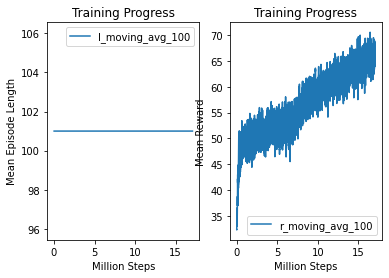

In [77]:
# visualizing training progress

from utils.utils import Simulation
from utils.visualization import plot_training_progress

sims = [Simulation('./outputs/Collins2018/A2C-LSTM20')]
plot_training_progress(sims[0].model_path)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


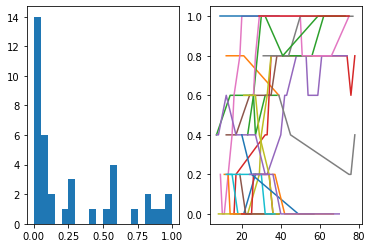

In [7]:
fig, axs = plt.subplots(1, 2)
# show the reward mean for each object, groupby each episode
# insight: network probably doesn't "learn"
df = sims[0].rollouts.copy()
mean_reward = pd.pivot_table(df, values = "rewards", index=['episode'], columns=['observations'])
axs[0].hist(mean_reward.to_numpy().reshape(1, -1)[0], bins=20)

# does the model remember the correct action after a reward?
# mostly yes
df_grouped = df.groupby(["observations", 'episode'])
for name, group in df_grouped:
    #print(group.rewards.tolist())
    series = group.rewards
    if series.sum() > 0:
        axs[1].plot(series.rolling(window=5).mean())
        
# does the model learn to attempt different actions after failed trials? 
# mostly
# insight: network should be quite larger than the optimal size

In [9]:
df.describe()

,episode,trial,rewards,observations,actions,curr_num_objects
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.990329,28.439072,0.294004,1.605416,1.537718,4.375242
std,2.806054,20.142772,0.456035,1.447736,0.752920,1.496251
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,3.000000,12.000000,0.000000,1.000000,1.000000,3.000000
50%,5.000000,25.000000,0.000000,1.000000,2.000000,3.000000
75%,7.000000,38.000000,1.000000,2.000000,2.000000,6.000000
max,9.000000,78.000000,1.000000,5.000000,2.000000,6.000000


In [ ]:
from stable_baselines.common.cmd_util import make_vec_env

from utils.utils import Simulation
from utils.visualization import plot_best_action_reversal, calc_stay_prob, plot_stay_prob, visualize_hidden_units
from envs.TwoStepTask import TwoStepTask
from envs.GuessBoundary import GuessBoundaryTask

env = TwoStepTask(prob_switch_reward=0.05, num_trials=200)
env = make_vec_env(lambda: env, n_envs=1)

sims = [Simulation('./outputs/A2C-LSTM10_Standard_PSwitch5e-2/train25000', env = env),
              Simulation('./outputs/A2C-LSTM10_Standard_PSwitch5e-2/train500000', env = env)]
            
fig, axs = plt.subplots(3, len(sims), figsize = (16, 16))
fig.suptitle('Training Steps: 25K / 500K', fontsize=30)
for ctr, sim in enumerate(sims):
    sim.evaluate()
    
    # first row: how fast can the model switch behaviors after a switch
    plotActionReversal(axs[0, ctr], sim.TestRollouts)
    
    # second row: MB or MF behavior?
    stayProb, _, _ = calcStayProb(sim.TestRollouts)
    plotStayProb(axs[1, ctr], stayProb)
    
    # third row: try to visualize the hidden units
    vis = visualizeH(axs[2, ctr], sim.TestRollouts)

In [38]:
behav_data = pd.read_csv('/Users/mhwu/Desktop/rochester/RL_projects/noisyMetaRL/behavior/Collins2018_data.csv')
print(behav_data.describe())
behav_data.head(10)

                 ID  learningblock         trial            ns          stim  \
count  90636.000000   90636.000000  90636.000000  90636.000000  90636.000000   
mean     161.285714       7.551205     48.355422      4.843373      2.920164   
std       57.593870       3.833973     46.842900      1.460177      1.609600   
min       83.000000       1.000000      1.000000      3.000000      1.000000   
25%      108.000000       5.000000     17.000000      3.000000      2.000000   
50%      133.000000       7.500000     34.000000      6.000000      3.000000   
75%      220.000000      11.000000     63.000000      6.000000      4.000000   
max      242.000000      14.000000    216.000000      6.000000      6.000000   

               iter     corchoice        choice           cor            rt  \
count  70980.000000  90636.000000  90636.000000  90636.000000  90636.000000   
mean       7.010144      2.029116      1.993645      0.765810      0.585451   
std        3.759475      0.807944      0.8

,ID,learningblock,trial,ns,stim,iter,corchoice,choice,cor,rt,pcor,delay,phase
0,83,1,1,3,1,1.0,1,3,0,0.294137,0.0,NaN,0
1,83,1,2,3,2,1.0,2,1,0,0.255660,0.0,NaN,0
2,83,1,3,3,3,1.0,2,2,1,0.186559,0.0,NaN,0
3,83,1,4,3,1,2.0,1,3,0,0.345196,0.0,NaN,0
4,83,1,5,3,3,2.0,2,2,1,0.224369,1.0,2.0,0
5,83,1,6,3,2,2.0,2,1,0,0.205919,0.0,NaN,0
6,83,1,7,3,2,3.0,2,2,1,0.363374,0.0,NaN,0
7,83,1,8,3,3,3.0,2,2,1,0.305843,2.0,3.0,0
8,83,1,9,3,1,3.0,1,1,1,0.307825,0.0,NaN,0
9,83,1,10,3,1,4.0,1,2,0,0.188878,1.0,1.0,0


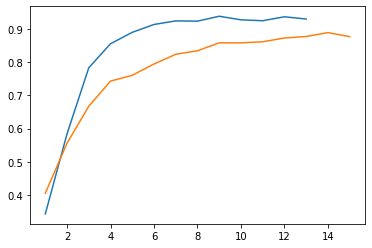

In [73]:
# plot Fig. 1A
# plot percentage correct vs stimulus iteration (one for ns=3, another for ns=6)
df = behav_data[(behav_data.phase == 0) & (behav_data.choice >= 0)].copy()
plt.plot(df[df.ns == 3].groupby('iter').cor.mean())
plt.plot(df[df.ns == 6].groupby('iter').cor.mean())

In [48]:
behav_data.ID.unique()

array([ 83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242])